In [1]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression

In [16]:
#학습된 모델 저장
import pickle
import os

In [367]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [498]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20

In [4]:
sample_submission = pd.read_csv("./_data/sample_submission.csv")
stock_list = pd.read_csv("./_data/stock_list.csv")
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x: str(x).zfill(6)) #zfill 숫자만큼 자릿수 맞춰 0 채우기

In [5]:
stock_code = '005930' #삼성전자
stock_code = '035420'
predict_date = '20211129'  # 29일의 종가 예측
period = 365  # 1년간의 데이터를 사용

In [6]:
predict_date = pd.to_datetime(predict_date)
end_date = predict_date - datetime.timedelta(days=1) # 예측날짜의 하루전의 테이터까지만 사용
start_date = end_date - datetime.timedelta(days=period) # 1년 전의 데이터까지 사용

In [7]:
start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime('%V')
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq='B'), columns = ['Date'])

In [112]:
max_weeknum

'47'

In [8]:
sample = fdr.DataReader(stock_code, start = start_date, end = end_date).reset_index()
sample = pd.merge(Business_days, sample, how = 'outer')
sample['weekday'] = sample.Date.apply(lambda x : x.weekday())
sample['weeknum'] = sample.Date.apply(lambda x : x.strftime('%V'))
sample= sample.ffill()
sample

,Date,Open,High,Low,Close,Volume,Change,weekday,weeknum
0,2020-11-30,286000.0,286500.0,277500.0,277500.0,1176272.0,-0.024605,0,49
1,2020-12-01,282000.0,286000.0,280000.0,285500.0,709278.0,0.028829,1,49
2,2020-12-02,287000.0,287000.0,282000.0,283500.0,601596.0,-0.007005,2,49
3,2020-12-03,285000.0,287000.0,283500.0,287000.0,740985.0,0.012346,3,49
4,2020-12-04,287500.0,295500.0,284500.0,294000.0,1174932.0,0.024390,4,49
...,...,...,...,...,...,...,...,...,...
255,2021-11-22,403000.0,411500.0,400500.0,410000.0,555854.0,0.014851,0,47
256,2021-11-23,401000.0,405000.0,399500.0,400000.0,682033.0,-0.024390,1,47
257,2021-11-24,399000.0,401000.0,392000.0,395000.0,554151.0,-0.012500,2,47
258,2021-11-25,400000.0,401000.0,395500.0,397000.0,323058.0,0.005063,3,47


In [9]:
kospi_ = pd.read_csv("./_data/kosdaq_kospi1.csv", parse_dates=[0])
kospi_ = pd.merge(Business_days, kospi_, how='inner')
kospi_= kospi_.ffill()
kospi_

,Date,KOSPI,KOSPI_VOLUME,KOSPI_P,KOSPI_FOREINGER,KOSPI_OVERTIME_VOLUME,KOSPI_OVERTIME_P,KOSPI_TOTAL,KOSDAQ,KOSDAQ_VOLUME,KOSDAQ_VOLUME_P,KOSDAQ_FOREINGER
0,2020-11-30,2591.34,128499,204460,-24378,131183.0,212318.0,17796350,886.11,173804,121538,-576
1,2020-12-01,2634.25,113515,157440,748,115113.0,159473.0,18094940,891.29,213327,120607,200
2,2020-12-02,2675.90,105506,168873,5181,107620.0,175067.0,18383640,899.34,189061,131009,285
3,2020-12-03,2696.22,80978,154123,2103,81707.0,156051.0,18526280,907.61,236118,164301,-279
4,2020-12-04,2731.45,173858,196317,7622,177890.0,198758.0,18774440,913.76,216759,160225,446
...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-22,3013.25,52370,127625,7969,53096.0,129455.0,22253250,1032.31,132032,145373,-1345
242,2021-11-23,2997.33,51640,106907,2824,52423.0,108305.0,22138060,1013.72,103775,116565,549
243,2021-11-24,2994.29,54011,106995,3186,55664.0,109635.0,22108040,1020.13,102360,111971,825
244,2021-11-25,2980.27,58674,92795,-925,59597.0,94011.0,21999500,1015.66,109746,116338,-817


In [10]:
data = pd.merge(kospi_, sample)

In [116]:
data

,Date,KOSPI,KOSPI_VOLUME,KOSPI_P,KOSPI_FOREINGER,KOSPI_OVERTIME_VOLUME,KOSPI_OVERTIME_P,KOSPI_TOTAL,KOSDAQ,KOSDAQ_VOLUME,KOSDAQ_VOLUME_P,KOSDAQ_FOREINGER,Open,High,Low,Close,Volume,Change,weekday,weeknum
0,2020-11-30,2591.34,128499,204460,-24378,131183.0,212318.0,17796350,886.11,173804,121538,-576,286000.0,286500.0,277500.0,277500.0,1176272.0,-0.024605,0,49
1,2020-12-01,2634.25,113515,157440,748,115113.0,159473.0,18094940,891.29,213327,120607,200,282000.0,286000.0,280000.0,285500.0,709278.0,0.028829,1,49
2,2020-12-02,2675.90,105506,168873,5181,107620.0,175067.0,18383640,899.34,189061,131009,285,287000.0,287000.0,282000.0,283500.0,601596.0,-0.007005,2,49
3,2020-12-03,2696.22,80978,154123,2103,81707.0,156051.0,18526280,907.61,236118,164301,-279,285000.0,287000.0,283500.0,287000.0,740985.0,0.012346,3,49
4,2020-12-04,2731.45,173858,196317,7622,177890.0,198758.0,18774440,913.76,216759,160225,446,287500.0,295500.0,284500.0,294000.0,1174932.0,0.024390,4,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2021-11-22,3013.25,52370,127625,7969,53096.0,129455.0,22253250,1032.31,132032,145373,-1345,403000.0,411500.0,400500.0,410000.0,555854.0,0.014851,0,47
242,2021-11-23,2997.33,51640,106907,2824,52423.0,108305.0,22138060,1013.72,103775,116565,549,401000.0,405000.0,399500.0,400000.0,682033.0,-0.024390,1,47
243,2021-11-24,2994.29,54011,106995,3186,55664.0,109635.0,22108040,1020.13,102360,111971,825,399000.0,401000.0,392000.0,395000.0,554151.0,-0.012500,2,47
244,2021-11-25,2980.27,58674,92795,-925,59597.0,94011.0,21999500,1015.66,109746,116338,-817,400000.0,401000.0,395500.0,397000.0,323058.0,0.005063,3,47


In [11]:
train_dataX = data.iloc[:-1,:]
train_datay = data.iloc[1:,:]
x_pred = data.iloc[-1:,:]
x_pred = x_pred.drop(columns=['Date','weeknum'])

In [18]:
from sklearn.ensemble import RandomForestRegressor
for i in range(1,6):
    X = train_dataX.iloc[:-i,:] # 5-i 일 전의 데이터를 훈련
    X = X.drop(columns=['Date','weeknum']).to_numpy()
    y = train_datay.iloc[i:,:]
    y = y['Close'].to_numpy()  # 5+i일 후를 예측
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pipe_rf = make_pipeline(StandardScaler(),PCA(n_components=3),
                            RandomForestRegressor(max_depth=5,random_state=11,))
    pipe_rf.fit(X_train, y_train)
    prediction = pipe_rf.predict(x_pred)

    print(f"{i}번째 예상종가 : {prediction}")
    print(f"테스트 정확도:{pipe_rf.score(X_test,y_test):.3f}")

1번째 예상종가 : [394049.24301752]
테스트 정확도:0.908
2번째 예상종가 : [392076.67044435]
테스트 정확도:0.885
3번째 예상종가 : [402620.9588011]
테스트 정확도:0.882
4번째 예상종가 : [397543.26167039]
테스트 정확도:0.876
5번째 예상종가 : [405674.93026242]
테스트 정확도:0.863


In [13]:
from sklearn import set_config
set_config(display='diagram')
pipe_rf

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=5, random_state=11))])

In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_rf, X=X_train,y=y_train, 
                                                        train_sizes=np.linspace(0.1,1.0,10),
                                                       cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

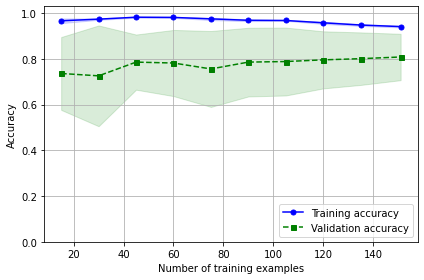

In [15]:
plt.plot(train_sizes, train_mean, color='blue',marker='o',
        markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean+train_std,
                train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',
        marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean+test_std,
                test_mean -test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.0, 1.03])
plt.tight_layout()
plt.show()

In [ ]:
dest = os.path.join(f'stock_close_predictor','pkl_objects')
if not os.path.exists(dest)
    os.makedirs(dest)
pickle.dump(pipe_rf, open(os.path.join(dest, '')))   

In [ ]:
import joblib
joblib.dump(grid.best_estimator_, 'filename.pkl')
# joblib.dump(grid.best_estimator_, 'filename.pkl', compress = 1)